In [1]:
# !pip install tensorflow==2.0.0
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-12-16 07:08:57--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-12-16 07:08:58 (132 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



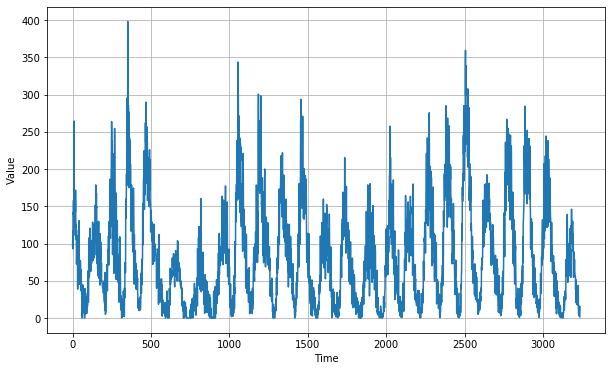

In [5]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

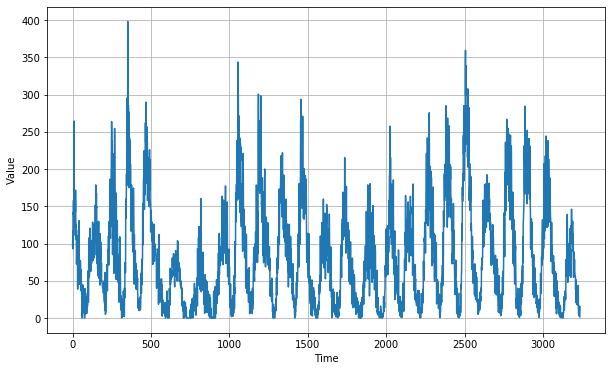

In [6]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 719ms/step - loss: 80.3072 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 1s 80ms/step - loss: 77.9405 - mae: 78.5897
Epoch 3/100
12/12 [==============================] - 1s 77ms/step - loss: 75.2415 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 80ms/step - loss: 72.2421 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 77ms/step - loss: 68.5303 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 79ms/step - loss: 64.8655 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 1s 75ms/step - loss: 61.1551 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 1s 78ms/step - loss: 58.2311 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 1s 76ms/step - loss: 54.7059 - mae: 55.5682
Epoch 10/100
12/12 [====

[1e-08, 0.0001, 0, 60]

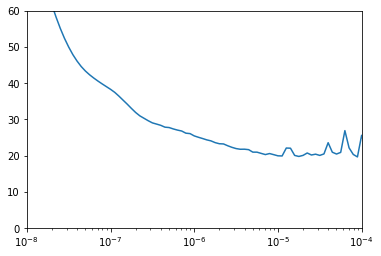

In [11]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [12]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 169ms/step - loss: 37.8901 - mae: 38.6064
Epoch 2/500
30/30 [==============================] - 1s 44ms/step - loss: 24.1482 - mae: 24.6128
Epoch 3/500
30/30 [==============================] - 1s 45ms/step - loss: 22.0321 - mae: 22.5238
Epoch 4/500
30/30 [==============================] - 1s 44ms/step - loss: 19.8086 - mae: 20.3070
Epoch 5/500
30/30 [==============================] - 1s 44ms/step - loss: 19.4717 - mae: 19.9697
Epoch 6/500
30/30 [==============================] - 1s 44ms/step - loss: 19.2056 - mae: 19.6952
Epoch 7/500
30/30 [==============================] - 1s 45ms/step - loss: 18.6448 - mae: 19.1354
Epoch 8/500
30/30 [==============================] - 1s 44ms/step - loss: 18.5297 - mae: 19.0056
Epoch 9/500
30/30 [==============================] - 1s 44ms/step - loss: 18.2318 - mae: 18.7357
Epoch 10/500
30/30 [==============================] - 1s 45ms/step - loss: 18.1510 - mae: 18.6594
Epoch 11/500
30/30 [========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

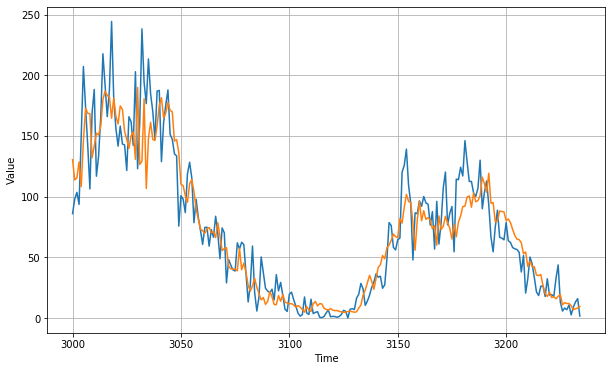

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.071606

<Figure size 432x288 with 0 Axes>

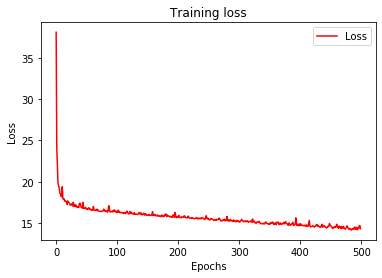

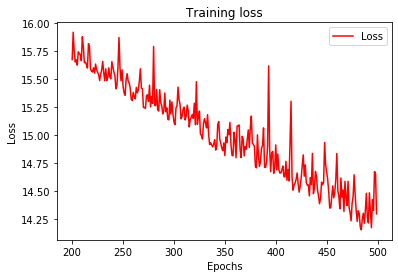

<Figure size 432x288 with 0 Axes>

In [16]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [17]:
print(rnn_forecast)

[130.45547   113.74978   115.44111   128.54291   108.227646  145.87534
 172.7945    168.61781   168.19875   131.92188   141.7022    152.26985
 150.72733   157.9533    179.95847   186.87474   183.27667   182.06842
 164.62776   181.25389   166.10333   159.86064   174.80016   171.77304
 153.84671   147.20778   139.67216   150.01202   153.21475   130.74658
 189.87958   126.46221   129.11098   180.57733   106.67009   148.01973
 161.26524   147.19061   146.25642   158.40672   175.08015   181.5169
 164.77715   169.02621   177.71402   170.96039   169.88982   145.77719
 147.0599    136.2427    110.22043   108.95725   100.96336    95.30887
 110.52041   114.0784    103.98871    89.983315   81.41585    73.34849
  71.79768    69.80592    73.1507     74.61424    70.360634   70.973274
  66.20346    78.43446    67.32575    55.505318   57.1254     57.990475
  42.515354   40.516693   40.234776   40.289898   38.854347   57.47692
  39.730217   45.21706    37.639248   26.703888   22.14345    26.487705
  32